In [1]:
pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
# import pandas_profiling as pp

import matplotlib.pyplot as plt; plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_recall_curve, classification_report
from IPython.display import clear_output
from scipy.stats import boxcox

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'predictive_analytics/Data-Mining-Cup/train.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
train = pd.read_csv(file_content_stream, delimiter = '|')

## Defining the file to be read from s3 bucket
file_key_2 = 'predictive_analytics/Data-Mining-Cup/test.csv'
bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading CSV file
test = pd.read_csv(file_content_stream_2, delimiter = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [ ]:
pp.ProfileReport(train)

In [3]:
## Negative Interactions ##
train['interaction_1'] = train['valuePerSecond'] * train['totalScanTimeInSeconds']
train['interaction_2'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['interaction_3'] = train['lineItemVoidsPerPosition'] * train['scannedLineItemsPerSecond']

## Positive Interactions ##
train['interaction_4'] = train['lineItemVoidsPerPosition'] * train['lineItemVoids']
train['interaction_5'] = train['valuePerSecond'] * train['grandTotal']
train['interaction_6'] = train['valuePerSecond'] * train['scannedLineItemsPerSecond']
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,interaction_5,interaction_6
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,54.70,29.0,0.006641,1.689655,2.838795,0.001428
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,27.36,14.0,0.046296,1.785714,6.931200,0.032840
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,62.16,13.0,0.001979,0.692308,2.548724,0.000352
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,92.31,29.0,0.004467,2.206897,4.757753,0.000835
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,81.53,27.0,0.006977,0.333333,15.458467,0.011905


In [4]:
## Box-Cox ##
train['valuePerSecond'] = train['valuePerSecond'] + .01
train['transformedValuePerSecond'] = boxcox(train['valuePerSecond'])[0]
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,interaction_5,interaction_6,transformedValuePerSecond
0,5,1054,54.70,7,0,3,0.027514,0.061898,0.241379,0,54.70,29.0,0.006641,1.689655,2.838795,0.001428,-4.193820
1,3,108,27.36,5,2,4,0.129630,0.263333,0.357143,0,27.36,14.0,0.046296,1.785714,6.931200,0.032840,-1.614606
2,3,1516,62.16,3,10,5,0.008575,0.051003,0.230769,0,62.16,13.0,0.001979,0.692308,2.548724,0.000352,-4.623961
3,6,1791,92.31,8,4,4,0.016192,0.061541,0.275862,0,92.31,29.0,0.004467,2.206897,4.757753,0.000835,-4.206321
4,5,430,81.53,3,7,2,0.062791,0.199605,0.111111,0,81.53,27.0,0.006977,0.333333,15.458467,0.011905,-2.031526


# Exercise 3

In [5]:
X = train.drop(columns = ['valuePerSecond', 'fraud'])
Y = train['fraud']
importance = list()
for i in (0, 100):
    print(i)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
    md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    importance.append(md.feature_importances_)
    clear_output()
    
pd.DataFrame({'Feature': X.columns.values,'Importance': pd.DataFrame(pd.DataFrame(importance).apply(np.mean, axis = 0))[0].values}).sort_values(by = 'Importance',ascending = False)

,Feature,Importance
0,trustLevel,0.306470
9,interaction_2,0.240947
6,scannedLineItemsPerSecond,0.084887
1,totalScanTimeInSeconds,0.057130
7,lineItemVoidsPerPosition,0.052981
11,interaction_4,0.038716
8,interaction_1,0.035493
14,transformedValuePerSecond,0.034730
13,interaction_6,0.033427
2,grandTotal,0.026270


The top three features are trustLevel, interaction_2, and scannedLineItemsPerSecond

In [6]:
train['feature_1'] = train['trustLevel'] * train['interaction_2']
train['feature_2'] = train['trustLevel'] * train['scannedLineItemsPerSecond']
train['feature_3'] = train['interaction_2'] * train['scannedLineItemsPerSecond']
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,interaction_5,interaction_6,transformedValuePerSecond,feature_1,feature_2,feature_3
0,5,1054,54.70,7,0,3,0.027514,0.061898,0.241379,0,54.70,29.0,0.006641,1.689655,2.838795,0.001428,-4.193820,145.0,0.137571,0.797913
1,3,108,27.36,5,2,4,0.129630,0.263333,0.357143,0,27.36,14.0,0.046296,1.785714,6.931200,0.032840,-1.614606,42.0,0.388889,1.814815
2,3,1516,62.16,3,10,5,0.008575,0.051003,0.230769,0,62.16,13.0,0.001979,0.692308,2.548724,0.000352,-4.623961,39.0,0.025726,0.111478
3,6,1791,92.31,8,4,4,0.016192,0.061541,0.275862,0,92.31,29.0,0.004467,2.206897,4.757753,0.000835,-4.206321,174.0,0.097152,0.469570
4,5,430,81.53,3,7,2,0.062791,0.199605,0.111111,0,81.53,27.0,0.006977,0.333333,15.458467,0.011905,-2.031526,135.0,0.313953,1.695349


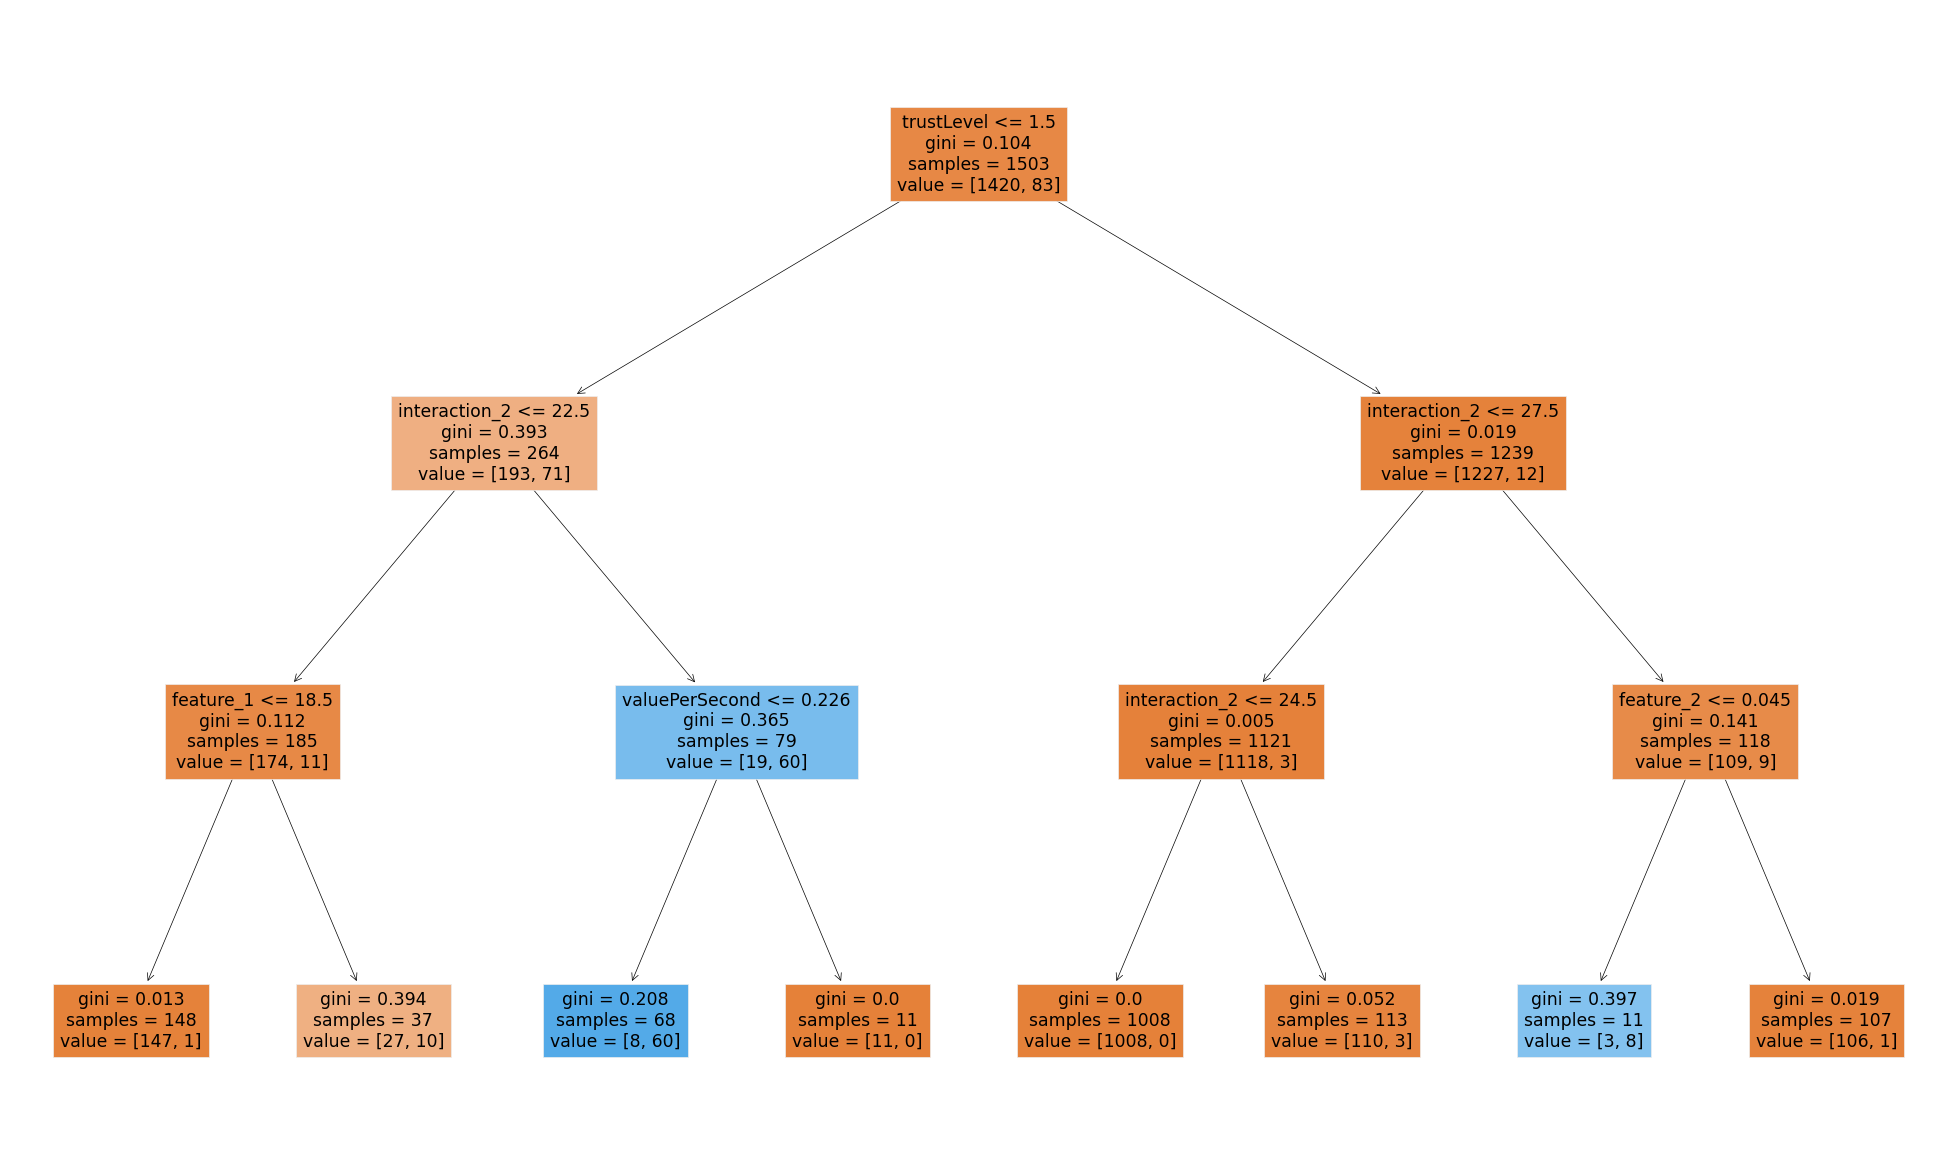

In [27]:
## decision tree ##
X = train.drop(columns = 'fraud')
Y = train['fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

%matplotlib inline
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = train.drop(columns = 'fraud').columns, filled = True);

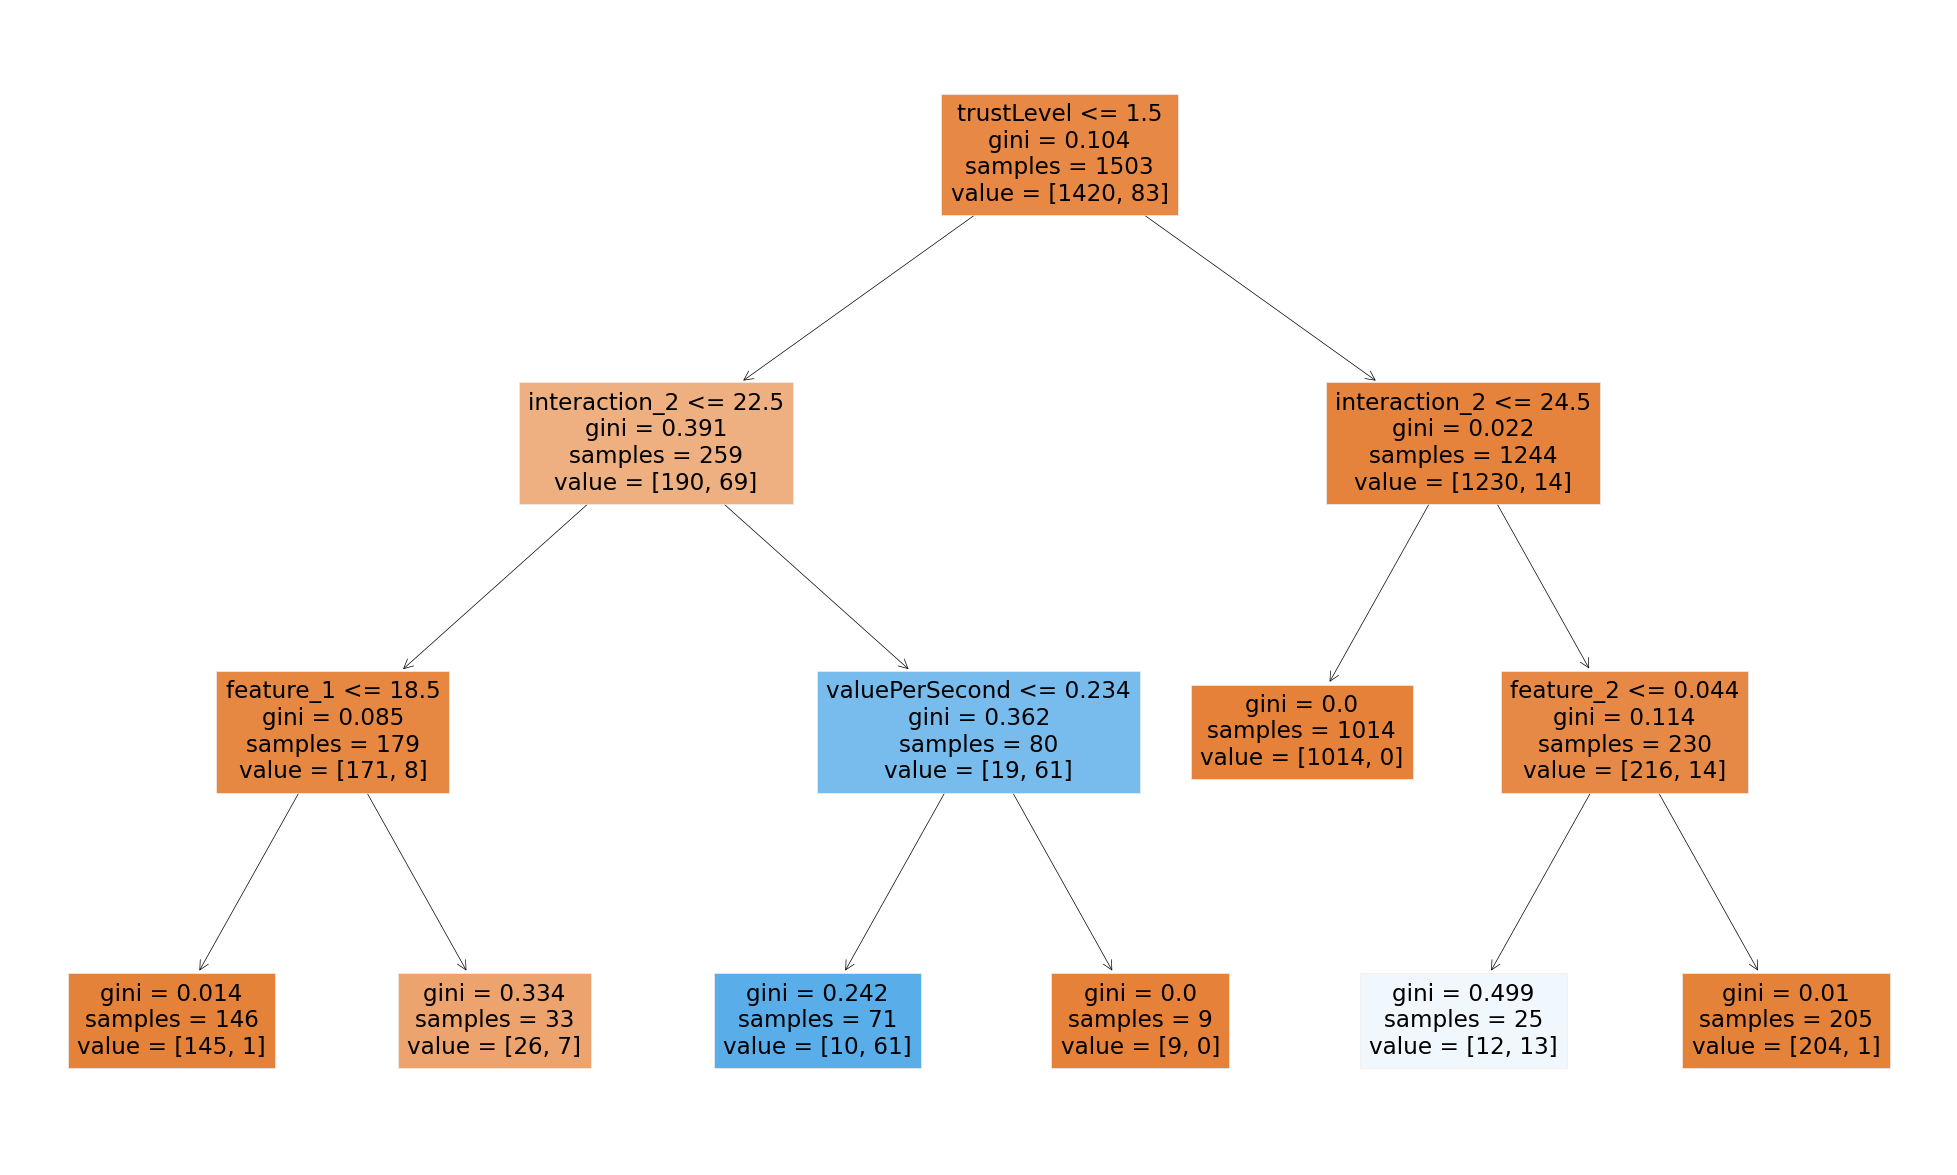

In [30]:
## decision tree ##
X = train.drop(columns = 'fraud')
Y = train['fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

%matplotlib inline
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = train.drop(columns = 'fraud').columns, filled = True);

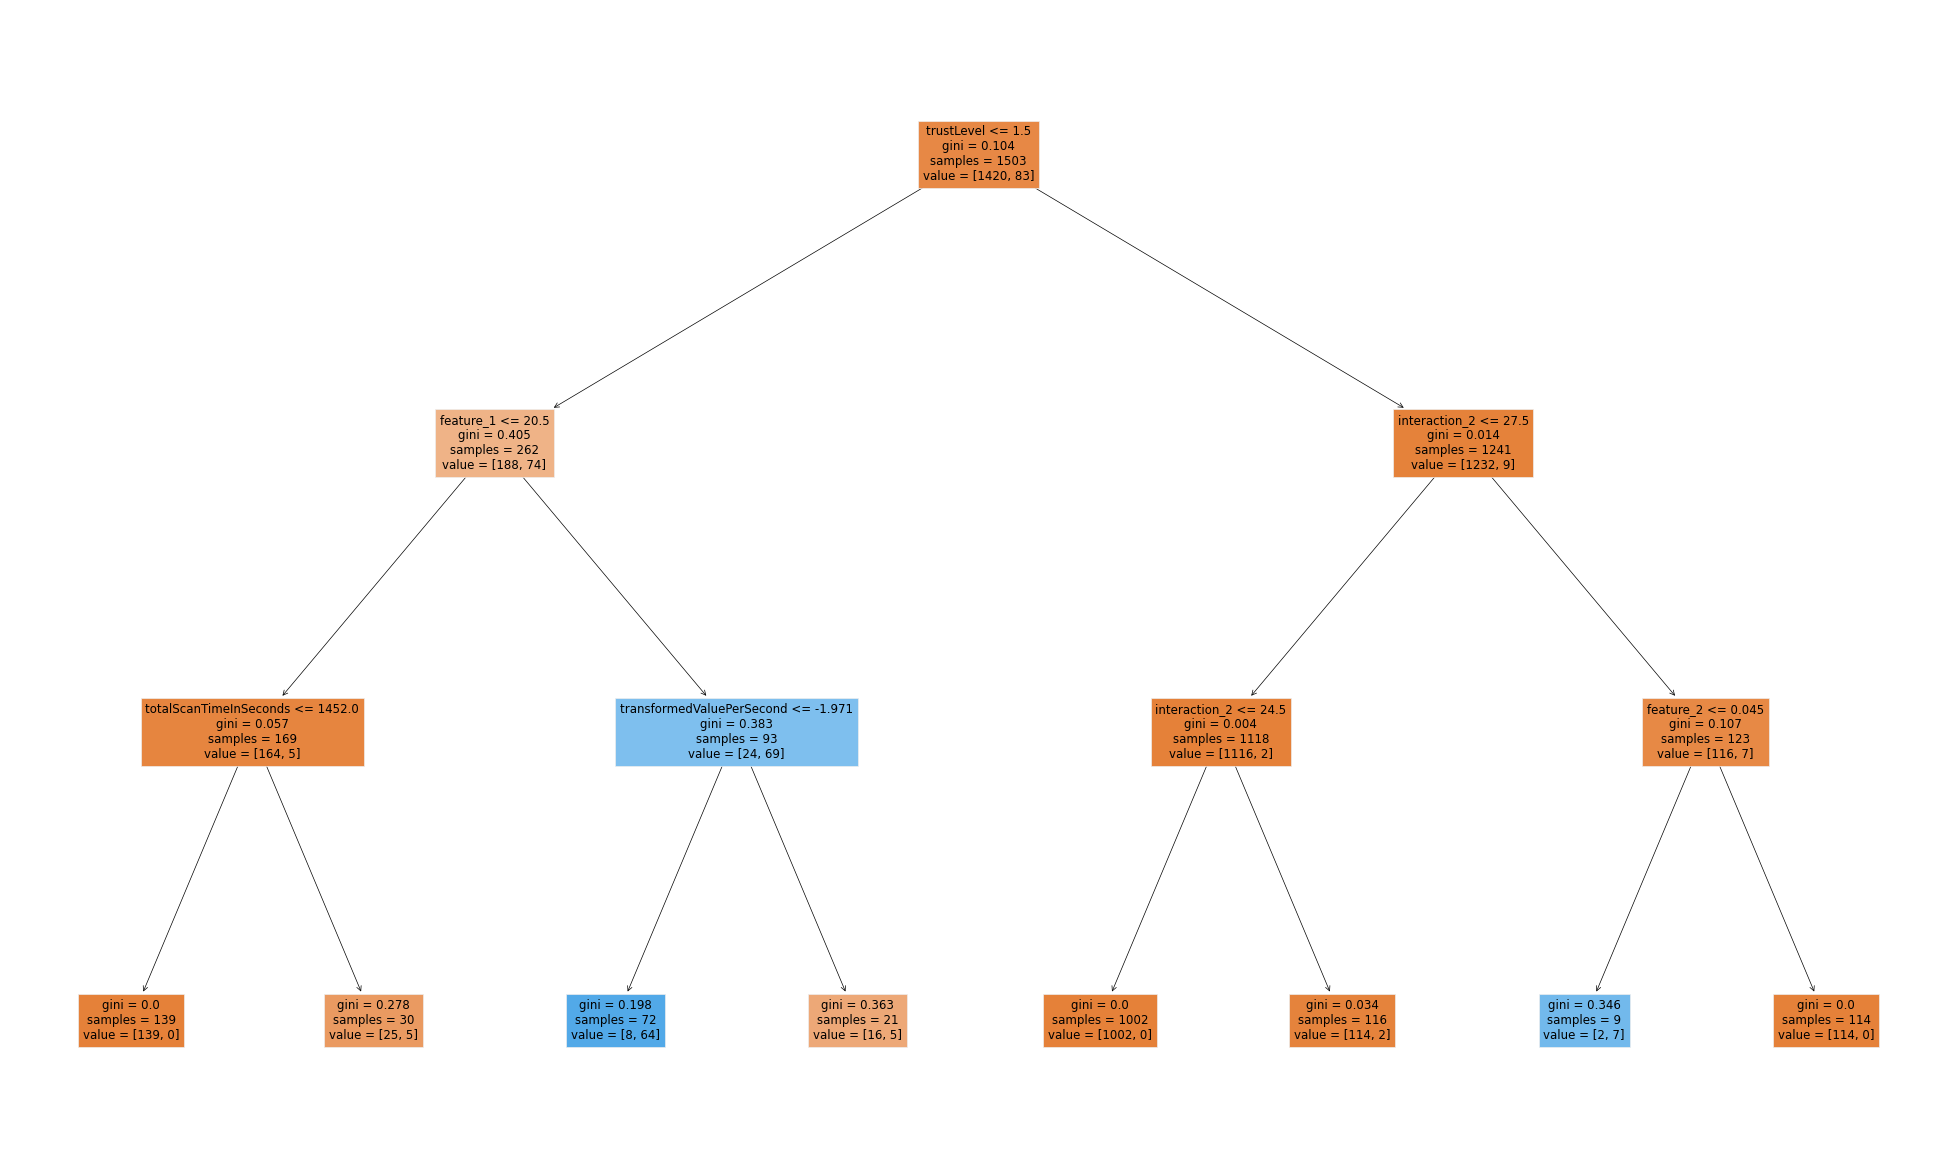

In [31]:
## decision tree ##
X = train.drop(columns = 'fraud')
Y = train['fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

%matplotlib inline
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = train.drop(columns = 'fraud').columns, filled = True);

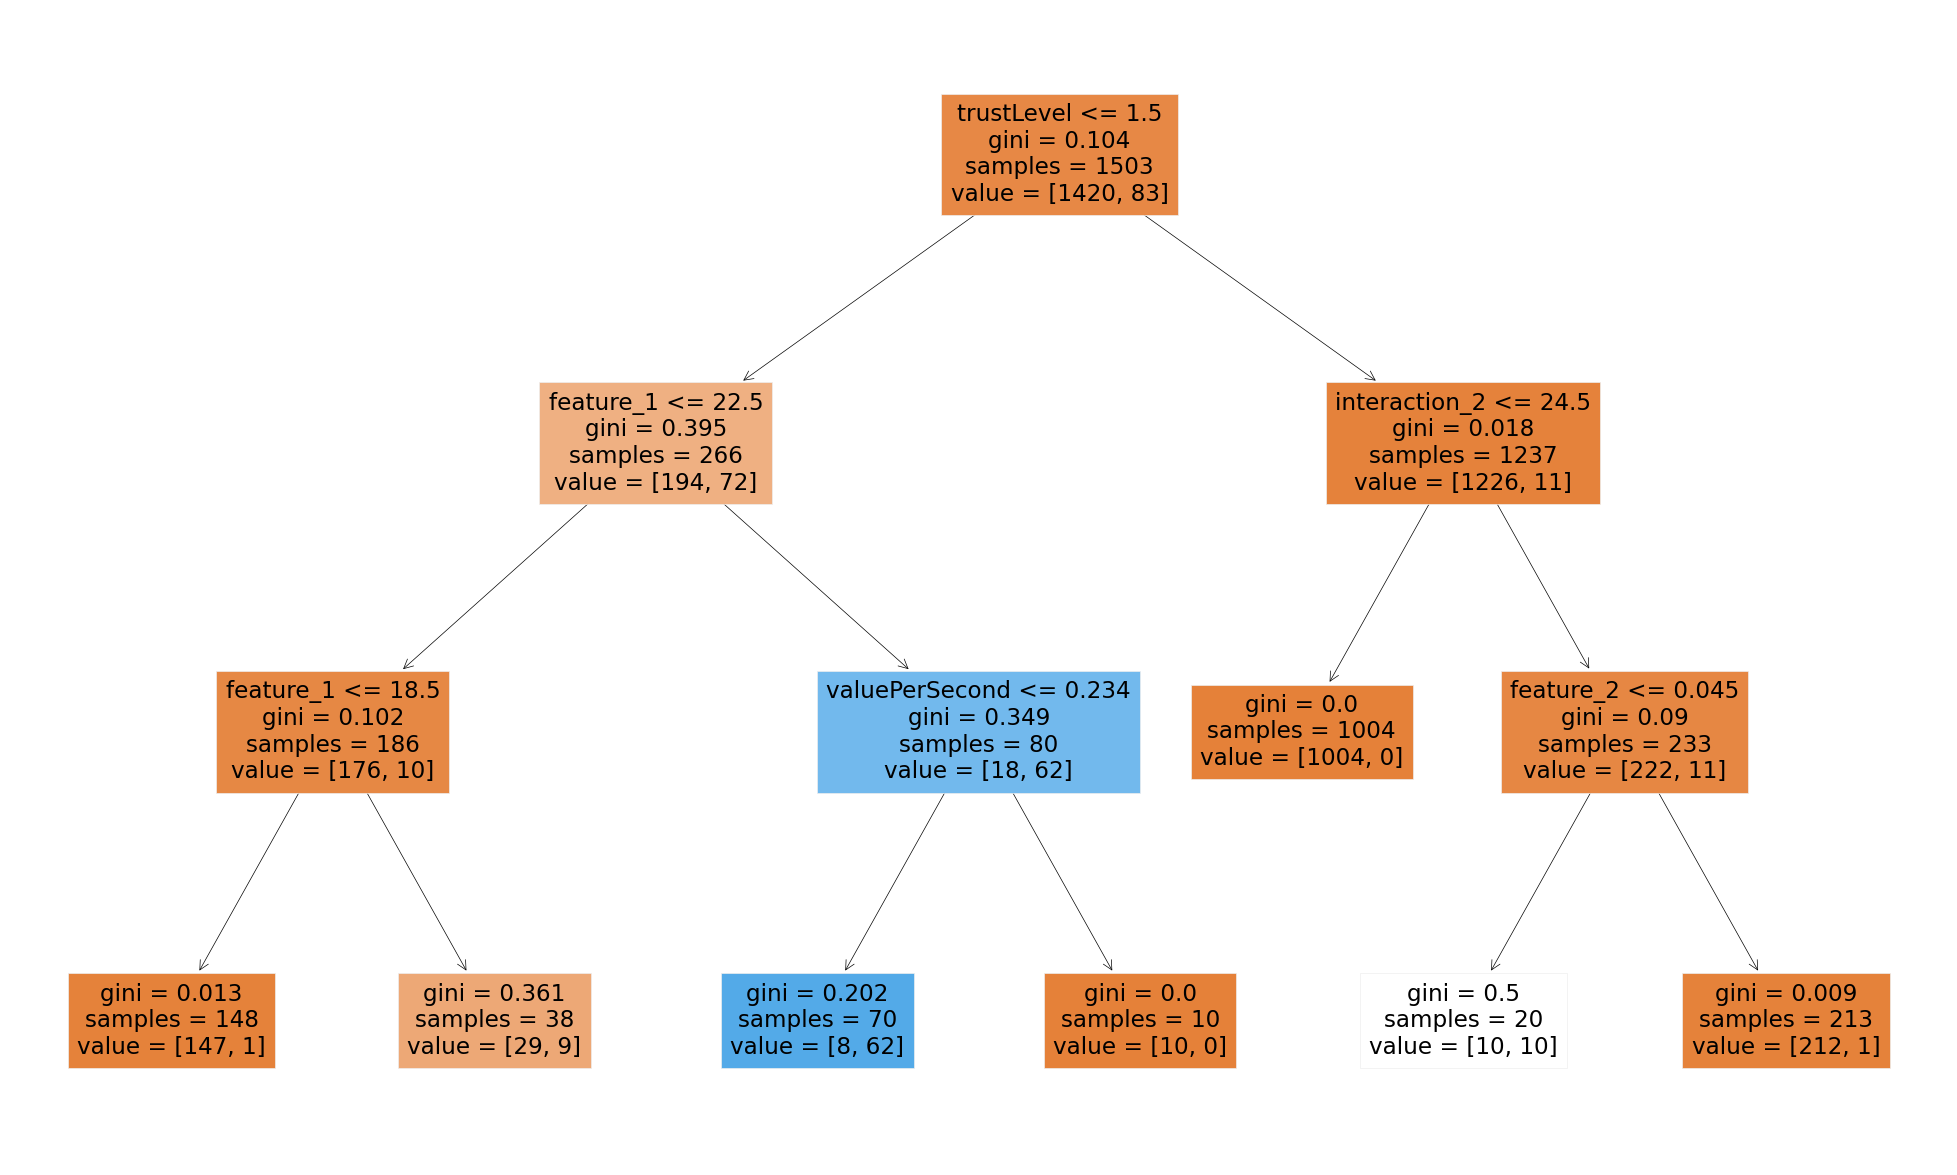

In [28]:
## decision tree ##
X = train.drop(columns = 'fraud')
Y = train['fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

%matplotlib inline
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = train.drop(columns = 'fraud').columns, filled = True);

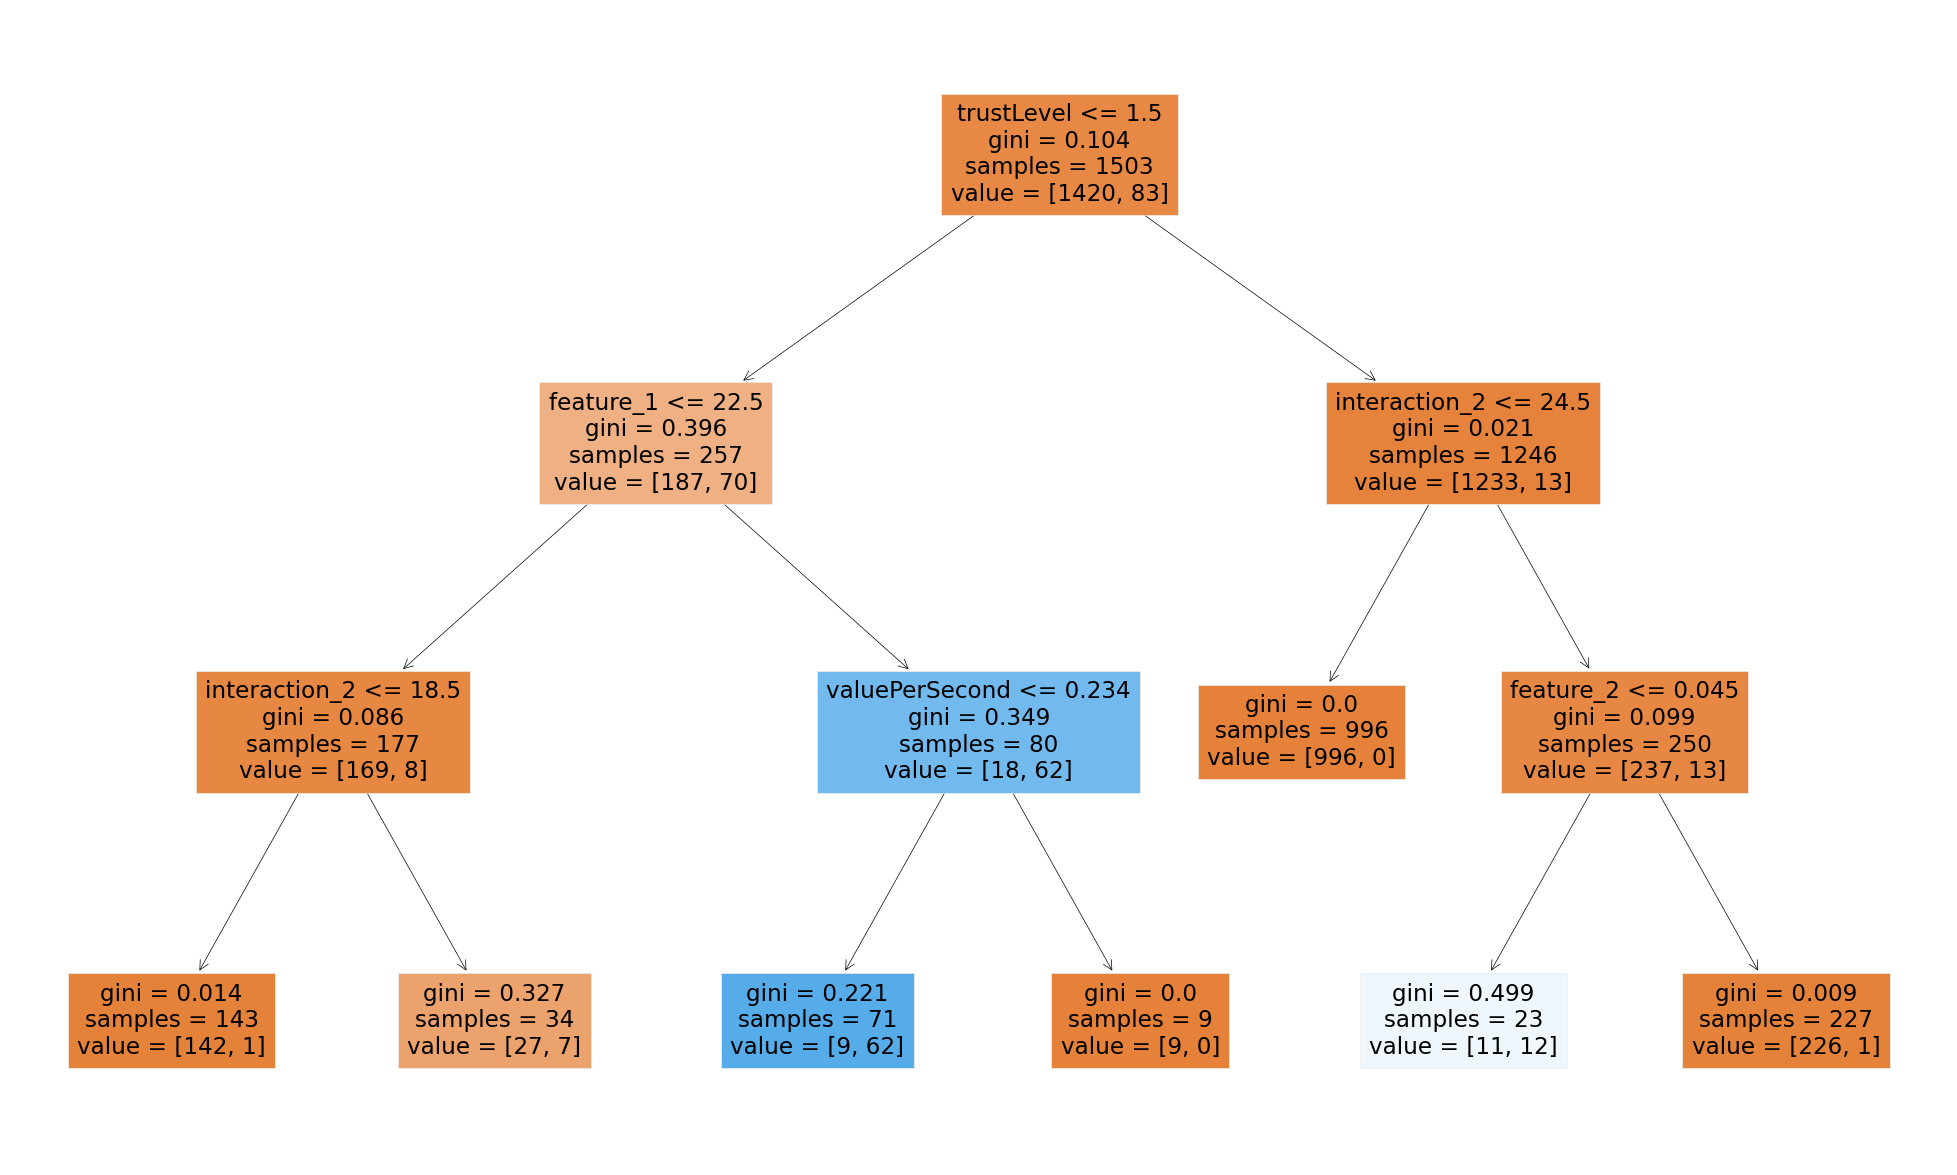

In [29]:
## decision tree ##
X = train.drop(columns = 'fraud')
Y = train['fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

%matplotlib inline
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = train.drop(columns = 'fraud').columns, filled = True);

I am seing a very clear interaction in my data that may help my future models. The interaction 2 feature that I created is an interaction between scanned line items per second, and total scan time in seconds. feature 1 is an interaction between this and trust level. This interaction seams to be able to seperate a good amount of 1s from my data set. These then are able to be seperated well from value per second. Since feature 1 involves interaction 2, my feature should be as follows: 
<br>
trustLevel <= 1.5 <br>
feature 1 > 21.83 <br>
valuePerSecond <= .234

In [7]:
train['feature_4'] = np.where((train['trustLevel'] <= 1.5) &
                              (train['feature_1'] > 21.83) &
                              (train['valuePerSecond'] > .234), 1, 0)
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,...,interaction_2,interaction_3,interaction_4,interaction_5,interaction_6,transformedValuePerSecond,feature_1,feature_2,feature_3,feature_4
0,5,1054,54.70,7,0,3,0.027514,0.061898,0.241379,0,...,29.0,0.006641,1.689655,2.838795,0.001428,-4.193820,145.0,0.137571,0.797913,0
1,3,108,27.36,5,2,4,0.129630,0.263333,0.357143,0,...,14.0,0.046296,1.785714,6.931200,0.032840,-1.614606,42.0,0.388889,1.814815,0
2,3,1516,62.16,3,10,5,0.008575,0.051003,0.230769,0,...,13.0,0.001979,0.692308,2.548724,0.000352,-4.623961,39.0,0.025726,0.111478,0
3,6,1791,92.31,8,4,4,0.016192,0.061541,0.275862,0,...,29.0,0.004467,2.206897,4.757753,0.000835,-4.206321,174.0,0.097152,0.469570,0
4,5,430,81.53,3,7,2,0.062791,0.199605,0.111111,0,...,27.0,0.006977,0.333333,15.458467,0.011905,-2.031526,135.0,0.313953,1.695349,0


In [8]:
## Engineer all features and interactions onto test ##
## Negative Interactions ##
test['interaction_1'] = test['valuePerSecond'] * test['totalScanTimeInSeconds']
test['interaction_2'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['interaction_3'] = test['lineItemVoidsPerPosition'] * test['scannedLineItemsPerSecond']

## Positive Interactions ##
test['interaction_4'] = test['lineItemVoidsPerPosition'] * test['lineItemVoids']
test['interaction_5'] = test['valuePerSecond'] * test['grandTotal']
test['interaction_6'] = test['valuePerSecond'] * test['scannedLineItemsPerSecond']

## Box-Cox ##
test['valuePerSecond'] = test['valuePerSecond'] + .01
test['transformedValuePerSecond'] = boxcox(test['valuePerSecond'])[0]

test['feature_1'] = test['trustLevel'] * test['interaction_2']
test['feature_2'] = test['trustLevel'] * test['scannedLineItemsPerSecond']
test['feature_3'] = test['interaction_2'] * test['scannedLineItemsPerSecond']

test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,interaction_1,interaction_2,interaction_3,interaction_4,interaction_5,interaction_6,transformedValuePerSecond,feature_1,feature_2,feature_3
0,4,467,88.48,4,8,4,0.014989,0.199465,0.571429,88.48,7.0,0.008565,2.285714,16.763834,0.002840,-2.033167,28.0,0.059957,0.104925
1,3,1004,58.99,7,6,1,0.026892,0.068755,0.259259,58.99,27.0,0.006972,1.814815,3.465956,0.001580,-3.971709,81.0,0.080677,0.726096
2,1,162,14.00,4,5,4,0.006173,0.096420,4.000000,14.00,1.0,0.024691,16.000000,1.209877,0.000533,-3.293124,1.0,0.006173,0.006173
3,5,532,84.79,9,3,4,0.026316,0.169380,0.642857,84.79,14.0,0.016917,5.785714,13.513805,0.004194,-2.294811,70.0,0.131579,0.368421
4,5,890,42.16,4,0,0,0.021348,0.057371,0.210526,42.16,19.0,0.004494,0.842105,1.997152,0.001011,-4.361982,95.0,0.106742,0.405618
